#### MCS-related precipitation distribution at different MCS phases

In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [26]:
%%time
prec_bins = np.arange(0,120.5,0.5)
samples = np.zeros((6,2,2,len(prec_bins)-1)) # (mcs_phase, surface_type, precip_type, bins)

year_list = np.arange(2001,2021)

# load era-5 land sea mask
landsea_mask = xr.open_dataset('/neelin2020/RGMA_feature_mask/ERA5_LandSeaMask_regrid.nc4').landseamask.sel(latitude=slice(-40,40))

for year in year_list:
    
    print('processing year: {}'.format(year))
    BL_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/envs_track/{}/tropics_extend'.format(year))
    # get lat-lon information for each track accordingly 
    stats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/')
    mcs_stats = xr.open_dataset(stats_dir / 'mcs_tracks_non2mcs_{}.tropics30NS.extend.nc'.format(year))

    ds_BL = []
    files = sorted(list(BL_dir.glob('*.nc')))

    for file in files: 
        
        data = xr.open_dataset(file) # read a single file of instantaneous BL measure
        # read precip
        precip_gpm = data.precipitationCal # (mm/hr)
        precip_era5 = data.mtpr # (mm/hr)
        
        # maskout for only the MCS area
        precip_gpm = precip_gpm.where(data.cloudtracknumber_nomergesplit > 0)
        precip_era5 = precip_era5.where(data.cloudtracknumber_nomergesplit > 0)        

        # get corresponding landsea mask at each phase and save into the same xarray coordinates
        track_num = int(file.name[-11:-6]) # MCS track number in that year
        track_info = mcs_stats.sel(tracks=track_num)
        idt_phase = [track_info.idt_ccs_init, track_info.idt_mcs_init, track_info.idt_mcs_grow,
                     track_info.idt_mcs_mature, track_info.idt_mcs_decay, track_info.idt_mcs_end]
        
        try: # some issues with sizes different from 40x40
        
            landsea_phase = []
            for idt in idt_phase:
                meanlat = mcs_stats.sel(tracks=track_num, times=idt).meanlat.values
                meanlon = mcs_stats.sel(tracks=track_num, times=idt).meanlon.values
                if meanlon < 0:
                    meanlon = 360 + meanlon
                # find nearest point
                idx_lat_nearest = np.argmin(abs(meanlat - landsea_mask.latitude.values))
                idx_lon_nearest = np.argmin(abs(meanlon - landsea_mask.longitude.values))
                # get the 10-deg landsea mask accordingly
                landsea_sub = landsea_mask.isel(latitude=slice(idx_lat_nearest-20, idx_lat_nearest+20),
                                                longitude=slice(idx_lon_nearest-20, idx_lon_nearest+20))
                landsea_phase.append(landsea_sub.values)
            landsea_phase = np.asarray(landsea_phase) # (6, 40, 40)
            ds_landsea = xr.Dataset(data_vars=dict(landsea_mask = (['mcs_phase','x','y'], landsea_phase)),
                                    coords=dict(mcs_phase = (['mcs_phase'], data.mcs_phase.values),
                                                x = (['x'], np.arange(0,40)),
                                                y = (['y'], np.arange(0,40)))
                                   )

            for p,phase in enumerate(data.mcs_phase.values):

                gpm_sub = precip_gpm.sel(mcs_phase=phase)
                era5_sub = precip_era5.sel(mcs_phase=phase)

                # ocean 
                gpm_sub_mask = gpm_sub.where(ds_landsea.landsea_mask == 100)
                era5_sub_mask = era5_sub.where(ds_landsea.landsea_mask == 100)
                (samples_sub, bins_edge) = np.histogram(gpm_sub_mask, bins=prec_bins) 
                samples[p,0,0,:] += samples_sub
                (samples_sub, bins_edge) = np.histogram(era5_sub_mask, bins=prec_bins) 
                samples[p,0,1,:] += samples_sub

                # land 
                gpm_sub_mask = gpm_sub.where(ds_landsea.landsea_mask < 100)
                era5_sub_mask = era5_sub.where(ds_landsea.landsea_mask < 100)
                (samples_sub, bins_edge) = np.histogram(gpm_sub_mask, bins=prec_bins) 
                samples[p,1,0,:] += samples_sub
                (samples_sub, bins_edge) = np.histogram(era5_sub_mask, bins=prec_bins) 
                samples[p,1,1,:] += samples_sub      
                
        except:
            
            continue
            
# save into xarray.dataset
ds_preciphist = xr.Dataset(data_vars = dict(samples = (['mcs_phase','surface_type','precip_type','bins_precip'],samples)),
                           coords = dict(mcs_phase = (['mcs_phase'], data.mcs_phase.values),
                                         surface_type = (['surface_type'], ['ocean','land']),
                                         precip_type = (['precip_type'], ['gpm','era5']),
                                         bins_precip = (['bins_precip'], prec_bins[:-1])),
                           attrs= dict(description='precipitation histogram of MCS-related grids. 2001-2010'))            

processing year: 2001
processing year: 2002
processing year: 2003
processing year: 2004
processing year: 2005
processing year: 2006
processing year: 2007
processing year: 2008
processing year: 2009
processing year: 2010
processing year: 2011
processing year: 2012
processing year: 2013
processing year: 2014
processing year: 2015
processing year: 2016
processing year: 2017
processing year: 2018
processing year: 2019
processing year: 2020
CPU times: user 3h 40min 26s, sys: 11min 1s, total: 3h 51min 27s
Wall time: 3h 54min


In [ ]:
ds_preciphist.to_netcdf('/scratch/wmtsai/temp_mcs/output_stats/MCSprecip_1Dhist_phases.2001.2020.nc')

#### plotting precip density distribution
- MCS phases
- land vs ocean

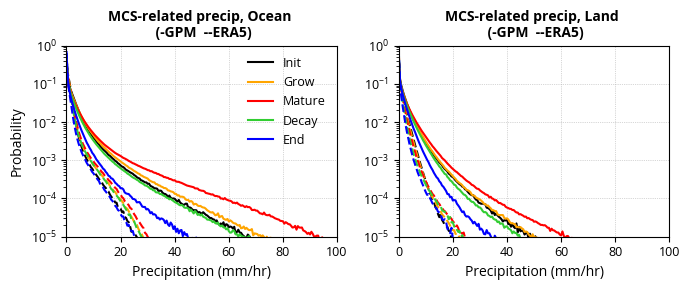

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(7,3))

ccolors = ['k','orange','r','limegreen','b']

for phase,ccolor in zip(ds_preciphist.mcs_phase.values[1:], ccolors):
    tmp = ds_preciphist.samples.sel(precip_type='gpm',mcs_phase=phase,surface_type='ocean')
    prob_gpm = tmp/tmp.sum()
    tmp2 = ds_preciphist.samples.sel(precip_type='era5',mcs_phase=phase,surface_type='ocean')
    prob_era5 = tmp2/tmp2.sum()
    
    ax1.plot(prob_gpm.bins_precip, prob_gpm, color=ccolor, label=phase)
    ax1.plot(prob_era5.bins_precip, prob_era5, color=ccolor,ls='--')
    
for phase,ccolor in zip(ds_preciphist.mcs_phase.values[1:], ccolors):
    tmp = ds_preciphist.samples.sel(precip_type='gpm',mcs_phase=phase,surface_type='land')
    prob_gpm = tmp/tmp.sum()
    tmp2 = ds_preciphist.samples.sel(precip_type='era5',mcs_phase=phase,surface_type='land')
    prob_era5 = tmp2/tmp2.sum()
    
    ax2.plot(prob_gpm.bins_precip, prob_gpm, color=ccolor, label=phase)
    ax2.plot(prob_era5.bins_precip, prob_era5, color=ccolor,ls='--')
    
ax1.set_title('MCS-related precip, Ocean \n (-GPM  --ERA5)', fontsize=10, fontweight='bold')
ax2.set_title('MCS-related precip, Land \n (-GPM  --ERA5)', fontsize=10, fontweight='bold')
    
ax1.set_xlabel('Precipitation (mm/hr)', fontsize=10) 
ax1.set_ylabel('Probability', fontsize=10) 
ax1.set_yscale('log')
ax1.legend(frameon=False, fontsize=9)
ax1.set_ylim([1e-5, 1])
ax1.set_xlim([0,100])

ax2.set_xlabel('Precipitation (mm/hr)', fontsize=10) 
#ax2.set_ylabel('Probability', fontsize=10) 
ax2.set_yscale('log')
ax2.set_ylim([1e-5, 1])
ax2.set_xlim([0,100])

ax1.grid(lw=0.5, ls=':')
ax2.grid(lw=0.5, ls=':')
ax1.tick_params(labelsize=9)
ax2.tick_params(labelsize=9)

plt.tight_layout()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/MCSprecip_probability_phases.pdf',
           bbox_inches='tight', transparent=False)